### Run it in colab from here: https://colab.research.google.com/drive/1tBQHVV6W4caKbdMwBAlRFcMzyASZ_uxO?usp=sharing

In [1]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [2]:
%cd {HOME}
!gdown '10zzs49pm90lG5EqJpuf9X-N-sQcSSl43' -O CCTV_Input.mp4

/content
Downloading...
From: https://drive.google.com/uc?id=10zzs49pm90lG5EqJpuf9X-N-sQcSSl43
To: /content/CCTV_Input.mp4
100% 17.2M/17.2M [00:01<00:00, 9.96MB/s]


In [9]:
SOURCE_VIDEO_PATH = f"{HOME}/CCTV_Input.mp4"

In [ ]:
!pip install ultralytics supervision

In [5]:
import cv2
from ultralytics import YOLO
import supervision as sv
import numpy as np

In [6]:
model = YOLO('yolov8n.pt')

100%|██████████| 6.25M/6.25M [00:00<00:00, 370MB/s]


In [11]:
CLASS_NAMES_DICT = model.model.names
print(CLASS_NAMES_DICT)

{0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'keyboard', 67: 'cell phone', 68: 'microw

In [51]:
selected_classes = CLASS_NAMES_DICT[0]
# if you want to track other object use the number from this map

In [52]:
color_palette  = sv.ColorPalette.DEFAULT

color_to_use = color_palette.by_idx(1)

# Run the model on a specific frame

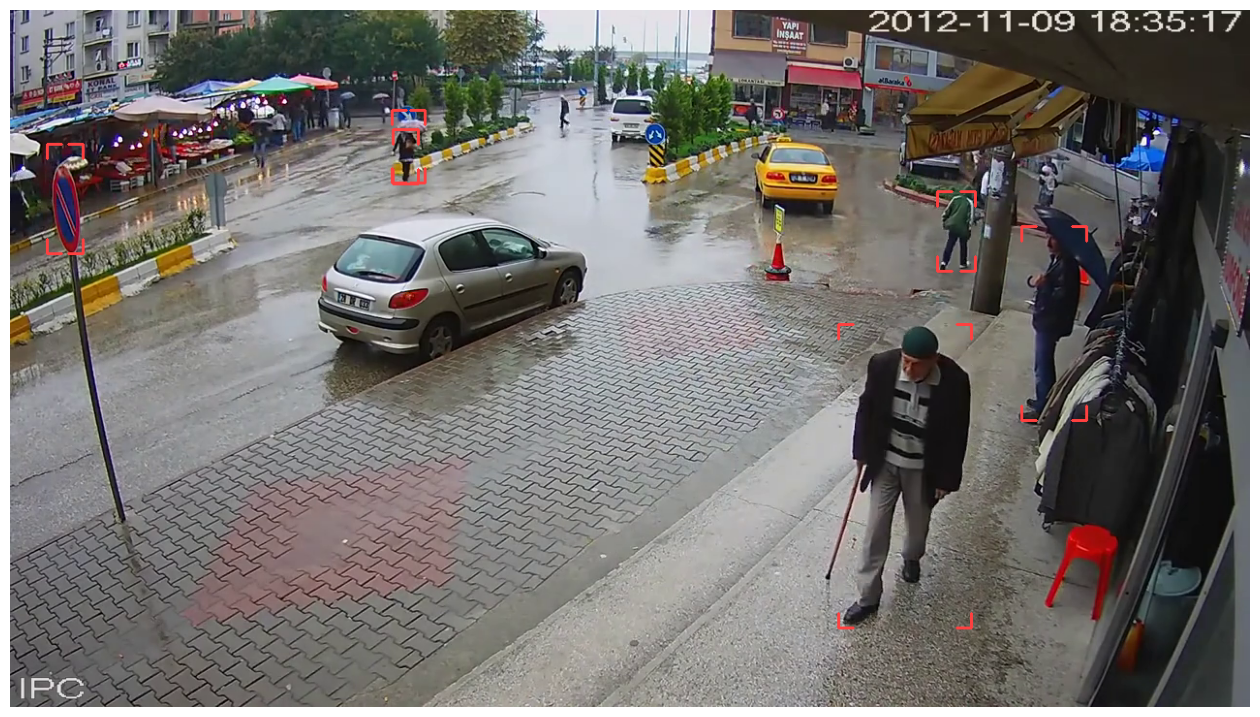

In [53]:
# Create frame generator
generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

# Create instance of BoxAnnotator
corner_annotator = sv.BoxCornerAnnotator(thickness=2, color= color_to_use)

# Specify the frame index you want to retrieve
frame_index = 600

# Create an iterator from the generator
iterator = iter(generator)

# Retrieve the specified frame
for i in range(frame_index + 1):  # +1 because we want to get frame_index and the loop starts at 0
    frame = next(iterator)

# Model prediction on the selected frame and conversion to supervision Detections
results = model(frame, verbose=False)[0]

# Convert to Detections
detections = sv.Detections.from_ultralytics(results)

# Only consider class id from selected_classes defined above
detections = detections[np.isin(detections.class_id, selected_classes)]

# Annotate and display frame
annotated_frame = corner_annotator.annotate(scene=frame, detections=detections)

%matplotlib inline
sv.plot_image(annotated_frame, (16, 16))

# Run the model on the full video

In [54]:
# output path
TARGET_VIDEO_PATH = f"{HOME}/Halo_output_video.mp4"
sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

# create BYTETracker instance
byte_tracker = sv.ByteTrack(track_thresh=0.25, track_buffer=30, match_thresh=0.8, frame_rate=30)

# create VideoInfo instance
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

# create frame generator
generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

# create LineZone instance, it is previously called LineCounter class
corner_annotator = sv.BoxCornerAnnotator(thickness=2)

# create LineZoneAnnotator instance, it is previously called LineCounterAnnotator class

# define call back function to be used in video processing
def callback(frame: np.ndarray, index:int) -> np.ndarray:
    # model prediction on single frame and conversion to supervision Detections
    results = model(frame, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)
    # only consider class id from selected_classes define above
    detections = detections[np.isin(detections.class_id, selected_classes)]
    # tracking detections
    detections = byte_tracker.update_with_detections(detections)
    labels = [
        f"{tracker_id} {model.model.names[class_id]} {confidence:0.2f}"
        for confidence, class_id, tracker_id
        in zip(detections.confidence, detections.class_id, detections.tracker_id)
    ]

    annotated_frame = corner_annotator.annotate(
        scene=frame.copy(),
        detections=detections
    )

    # return frame with box annotated result
    return annotated_frame


# process the whole video
sv.process_video(
    source_path = SOURCE_VIDEO_PATH,
    target_path = TARGET_VIDEO_PATH,
    callback=callback
)


SupervisionWarnings: `track_buffer` in `ByteTrack.__init__` is deprecated and will be remove in `supervision-0.23.0`. Use 'lost_track_buffer' instead.
SupervisionWarnings: `track_thresh` in `ByteTrack.__init__` is deprecated and will be remove in `supervision-0.23.0`. Use 'track_activation_threshold' instead.
SupervisionWarnings: `match_thresh` in `ByteTrack.__init__` is deprecated and will be remove in `supervision-0.23.0`. Use 'minimum_matching_threshold' instead.


# to download the output file (ob colab)

In [55]:
from google.colab import files

# Specify the path to your video file
file_path = '/content/Halo_output_video.mp4'

# Download the file
files.download(file_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>